# Sentiment Analysis

In [1]:
# install libraries
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 44.7 MB/s eta 0:00:0000:0100:01


In [2]:
# import libraries
import os
import re
import nltk
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D, Bidirectional, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [3]:
# download wordnet, stopwords, omw
nltk.download('stopwords')
stopwords = stopwords.words('english')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# declare constants
DATASET_FOLDER = '/datasets/sentiment-analysis-dataset'
DATASET_FILENAME = 'training.1600000.processed.noemoticon.csv'
DATASET_COLUMNS = ['sentiment', 'id', 'timestamp', 'flag', 'user', 'text']
TEXT_PREPROCESS_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 30
W2V_MIN_COUNT = 10
MAX_LENGTH = 300
POSITIVE = 'Positive'
NEGATIVE = 'Negative'
NEUTRAL = 'Neutral'
SENTIMENT_THRESHOLD = 0.5
SENTIMENT_THRESHOLDS = (0.4, 0.6)
SA_MODEL = 'sa_model.keras'
TOKENIZER = 'tokenizer.pkl'
MODELS_FOLDER = 'models'

In [5]:
# dataset path
dataset_path = os.path.join(DATASET_FOLDER, DATASET_FILENAME)
dataset_path

'/datasets/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv'

## Data Ingestion

In [6]:
# read dataset
df = pd.read_csv(dataset_path, encoding='ISO-8859-1', names=DATASET_COLUMNS)
df.head()

,sentiment,id,timestamp,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
# print shape
df.shape

(1600000, 6)

In [8]:
# print info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   timestamp  1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
# Check for nulls
df.isna().sum()

sentiment    0
id           0
timestamp    0
flag         0
user         0
text         0
dtype: int64

In [10]:
# print unique values of sentiment column
df['sentiment'].unique()

array([0, 4])

In [11]:
# target is balanced
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

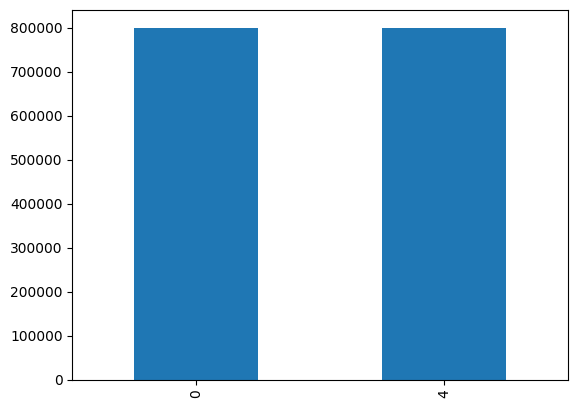

In [12]:
# plot sentiment
df['sentiment'].value_counts().plot(kind='bar');

## Data Preprocessing

Convert Sentiment to String
* 0 - Negative
* 4 - Positive

In [13]:
# map sentiment integer to string
sentiment_map = {
                0: 'Negative', 
                4: 'Positive'
            }

In [14]:
# convert sentiment to string
df['sentiment'] = df['sentiment'].apply(lambda x: sentiment_map[int(x)])
df.sample(5)

,sentiment,id,timestamp,flag,user,text
404828,Negative,2058515942,Sat Jun 06 15:05:43 PDT 2009,NO_QUERY,theswagflu,rt @jerzicuai post pics and no one checks them...
1206466,Positive,1986812597,Sun May 31 19:21:05 PDT 2009,NO_QUERY,karlaanarlaa,Such a goood weekendd do not want to go to sc...
409340,Negative,2059623663,Sat Jun 06 17:18:18 PDT 2009,NO_QUERY,MissNattyBaby,@godannygo Danny Sorry About Earlyer E Cut The...
534174,Negative,2197440336,Tue Jun 16 13:47:14 PDT 2009,NO_QUERY,pekav,@nclstu I didn't even know twitter was going d...
53282,Negative,1680157297,Sat May 02 11:02:01 PDT 2009,NO_QUERY,Wyldceltic1,"And of course, I finally have some $$ to buy t..."


In [15]:
# function to preprocess the text
def preprocess_text(text, lemmatize=False):
    # exclude hyperlinks, usernames and special characters
    text = re.sub(TEXT_PREPROCESS_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stopwords:
            if lemmatize:
                tokens.append(lemmatizer.lemmatize(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)

In [16]:
# clean the text for model training
df['clean_text'] = df['text'].apply(lambda text: preprocess_text(text, True))
df[['clean_text', 'sentiment']].head()

,clean_text,sentiment
0,awww bummer shoulda got david carr third day,Negative
1,upset update facebook texting might cry result...,Negative
2,dived many time ball managed save 50 rest go b...,Negative
3,whole body feel itchy like fire,Negative
4,behaving mad see,Negative


### Split the dataset

In [17]:
# create X and y
X = df['clean_text']
y = df['sentiment']

In [18]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120000,), (480000,), (1120000,), (480000,))

### Generate Word Embeddings using Word2Vec

`word2vec is an algorithm to train word embeddings: given a raw text, it calculates a word vector for every word in the vocabulary. These vectors can be used in other applications, thus they form a pretrained model.`

In [19]:
# split text into tokens
train_documents = [text.split() for text in X_train]
len(train_documents)

1120000

In [20]:
# initialize word2vec
w2v_model = Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)

In [21]:
# build vocabulary
w2v_model.build_vocab(train_documents)

In [22]:
# train the word2vec model
w2v_model.train(train_documents, total_examples=len(train_documents), epochs=W2V_EPOCH)

(214340278, 242318700)

### Tokenize the Text

In [23]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print('Total Words in Vocabulary', vocab_size)

Total Words in Vocabulary 255989


In [24]:
# pad sequences
X_train_ps = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LENGTH)
X_test_ps = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LENGTH)

In [25]:
# encode the sentiments
sentiments = df['sentiment'].unique().tolist()
sentiments

['Negative', 'Positive']

In [26]:
# perform label encoding
encoder = LabelEncoder()
encoder.fit(y_train)

y_train_le = encoder.transform(y_train)
y_test_le = encoder.transform(y_test)

y_train_le = y_train_le.reshape(-1, 1)
y_test_le = y_test_le.reshape(-1, 1)

print('y_train_le', y_train_le.shape)
print('y_test_le', y_test_le.shape)

y_train_le (1120000, 1)
y_test_le (480000, 1)


In [27]:
# print shapes
X_train_ps.shape, y_train_le.shape, X_test_ps.shape, y_test_le.shape

((1120000, 300), (1120000, 1), (480000, 300), (480000, 1))

## Build and Train the Model

In [28]:
# generate embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(255989, 300)


In [29]:
# build the model
sa_model = Sequential()
sa_model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))
sa_model.add(SpatialDropout1D(0.2))
sa_model.add(Conv1D(64, 5, activation='relu'))
sa_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
sa_model.add(Dense(512, activation='relu'))
sa_model.add(Dropout(0.5))
sa_model.add(Dense(512, activation='relu'))
sa_model.add(Dense(1, activation='sigmoid'))

In [30]:
# print model summary
sa_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          76796700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0

In [31]:
# compile the model
sa_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# initialize call backs
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [33]:
# train the model
history = sa_model.fit(X_train_ps, 
                    y_train_le,
                    batch_size=1024,
                    epochs=5,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/5
875/875 [==============================] - 987s 1s/step - loss: 0.4885 - accuracy: 0.7612 - val_loss: 0.4596 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 2/5
875/875 [==============================] - 977s 1s/step - loss: 0.4650 - accuracy: 0.7765 - val_loss: 0.4525 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 3/5
875/875 [==============================] - 978s 1s/step - loss: 0.4569 - accuracy: 0.7821 - val_loss: 0.4489 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/5
875/875 [==============================] - 978s 1s/step - loss: 0.4512 - accuracy: 0.7854 - val_loss: 0.4473 - val_accuracy: 0.7881 - lr: 0.0010
Epoch 5/5
875/875 [==============================] - 983s 1s/step - loss: 0.4472 - accuracy: 0.7877 - val_loss: 0.4456 - val_accuracy: 0.7885 - lr: 0.0010


## Model Evaluation

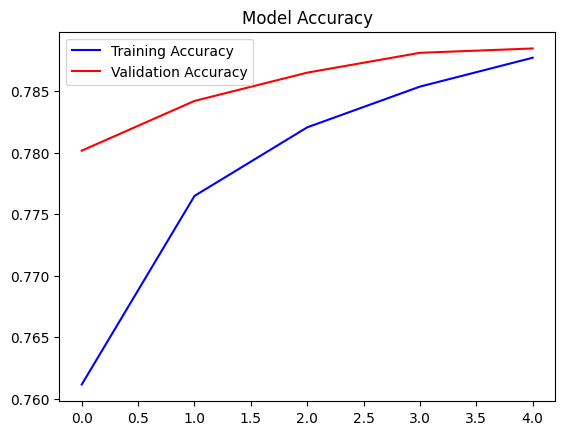

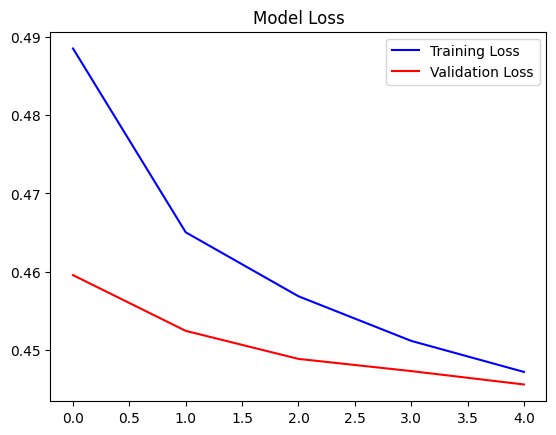

In [34]:
# visualize the metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.legend()
 
plt.show()

In [35]:
# function to generate sentiment from score
def generate_sentiment(score, include_neutral=False):
    if include_neutral:
        sentiment = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            sentiment = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            sentiment = POSITIVE
    else:
        return NEGATIVE if score < SENTIMENT_THRESHOLD else POSITIVE
    return sentiment

In [36]:
# model prediction
y_pred_1d = []
y_test_1d = list(y_test_le)
scores = sa_model.predict(X_test_ps, verbose=1)
y_pred_1d = [0 if score < SENTIMENT_THRESHOLD else 1 for score in scores]

15000/15000 [==============================] - 2501s 167ms/step


In [37]:
# print classification report
pd.DataFrame(classification_report(y_test_1d, y_pred_1d, output_dict=True)).T

,precision,recall,f1-score,support
0,0.802582,0.766048,0.783890,239361.000000
1,0.777371,0.812570,0.794581,240639.000000
accuracy,0.789371,0.789371,0.789371,0.789371
macro avg,0.789977,0.789309,0.789235,480000.000000
weighted avg,0.789943,0.789371,0.789249,480000.000000


In [38]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

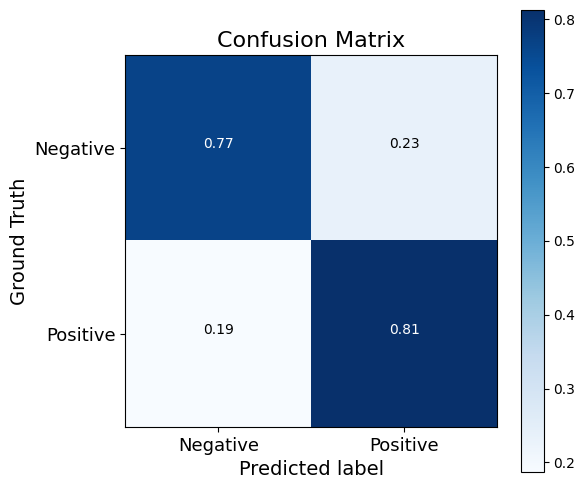

In [39]:
# display confusion matrix
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d, labels=[0, 1])
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=sentiments, title="Confusion Matrix")
plt.show()

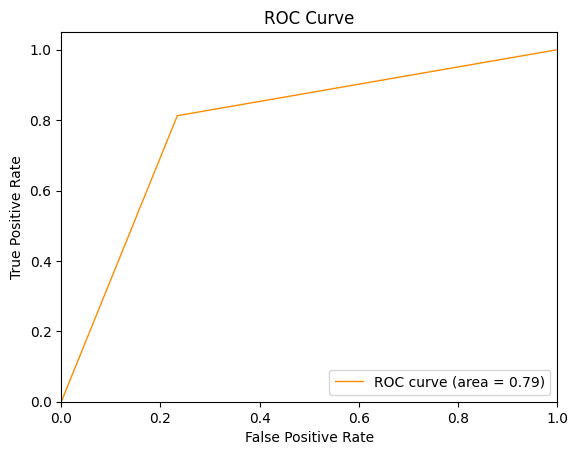

In [40]:
# display ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_1d, y_pred_1d)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
# function to predict sentiment from text
def predict_sentiment(text):
    # preprocess text
    text = preprocess_text(text, True)
    # tokenize text
    padded_text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_LENGTH)
    # generate prediction
    score = sa_model.predict([padded_text])[0]
    # compute sentiment
    sentiment = generate_sentiment(score)

    return {'sentiment': sentiment, 'score': float(score[0])}  

In [42]:
predict_sentiment("DigitalOcean's products provide a seamless and user-friendly experience, offering reliable and scalable solutions that empower developers to effortlessly deploy and manage applications with efficiency and ease.")

1/1 [==============================] - 1s 646ms/step


{'sentiment': 'Positive', 'score': 0.7094898819923401}

In [43]:
predict_sentiment("While DigitalOcean's products offer reasonable performance, the lack of comprehensive customer support and occasional downtime can be frustrating for users seeking a more robust and reliable hosting solution.")

1/1 [==============================] - 0s 288ms/step


{'sentiment': 'Negative', 'score': 0.11708605289459229}

## Save the Models

In [44]:
# saved models path
models_path = os.path.join(MODELS_FOLDER + '/')
models_path

'models/'

In [45]:
# save models
sa_model.save(models_path + SA_MODEL)
pickle.dump(tokenizer, open(models_path + TOKENIZER, 'wb'))

## Load Saved Models

In [46]:
# load sentiment analysis model
loaded_sa_model = tf.keras.models.load_model(models_path + SA_MODEL)
loaded_sa_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          76796700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0

In [47]:
# load tokenizer
loaded_tokenizer_model = pickle.load(open(models_path + TOKENIZER, 'rb'))

## Predict from Loaded Models 

In [48]:
# function to predict sentiment from loaded models
def infer_sentiment(text):
    # preprocess text
    text = preprocess_text(text, True)
    # tokenize text
    padded_text = pad_sequences(loaded_tokenizer_model.texts_to_sequences([text]), maxlen=MAX_LENGTH)
    # generate prediction
    score = loaded_sa_model.predict([padded_text])[0]
    # compute sentiment
    sentiment = generate_sentiment(score)

    return {'sentiment': sentiment, 'score': float(score[0])}  

In [49]:
infer_sentiment("DigitalOcean's products provide a seamless and user-friendly experience, offering reliable and scalable solutions that empower developers to effortlessly deploy and manage applications with efficiency and ease.")

1/1 [==============================] - 1s 642ms/step


{'sentiment': 'Positive', 'score': 0.7094898819923401}

In [50]:
infer_sentiment("While DigitalOcean's products offer reasonable performance, the lack of comprehensive customer support and occasional downtime can be frustrating for users seeking a more robust and reliable hosting solution.")

1/1 [==============================] - 0s 216ms/step


{'sentiment': 'Negative', 'score': 0.11708605289459229}